In [2]:
import nltk
import re
from nltk.corpus import gutenberg
from operator import itemgetter 
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

nltk.download('stopwords')
from nltk.corpus import stopwords
stopword_list = list(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rapha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def parse_document(document, sent_tokenize=False):
    document = re.sub('\n', ' ', document)
    if isinstance(document, str):
        document = document
    elif isinstance(document, unicode):
        return unicodedata.normalize(
            'NFKD', document).encode('ascii', 'ignore')
    else:
        raise ValueError('Document is not string or unicode!')
    document = document.strip()
    sentences = nltk.sent_tokenize(document)
    sentences = [sentence.strip() for sentence in sentences]

    return sentences if sent_tokenize else ' '.join(sentences)

In [4]:
# Home-made normalizer - New version for tokenization
def normalize_corpus(sent_corpus, remove_whitespace = False, remove_punc = False, 
                     remove_stopwords = True, all_lower = False, text_lemmatization = False, tokenize = False ):
    cleaned_array=[]
    lemmatizer = WordNetLemmatizer()
    for sent in sent_corpus:
        cleaned_sent = ""
        for item in nltk.word_tokenize(sent):
            if text_lemmatization == True:
                item = lemmatizer.lemmatize(item)
            if all_lower == True:
                item = item.lower() 
            if remove_punc == True:
                item = re.sub(r'[^A-Za-z0-9]','', item)
            if remove_stopwords == True and item.lower() not in stopword_list:
                cleaned_sent += item+' ' 
            elif remove_stopwords == False:
                cleaned_sent += item+' '
        if tokenize == True:   
            #print(cleaned_sent)
            cleaned_array.append(nltk.word_tokenize(cleaned_sent))
        else:
            cleaned_array.append(cleaned_sent)
    return cleaned_array

In [5]:
# load corpus
alice = gutenberg.sents(fileids='carroll-alice.txt')
alice = [' '.join(ts) for ts in alice]
norm_alice = normalize_corpus(alice, remove_punc=True, remove_stopwords=True,text_lemmatization=False)

In [6]:
alice[2:5]

['Down the Rabbit - Hole',
 "Alice was beginning to get very tired of sitting by her sister on the bank , and of having nothing to do : once or twice she had peeped into the book her sister was reading , but it had no pictures or conversations in it , ' and what is the use of a book ,' thought Alice ' without pictures or conversation ?'",
 'So she was considering in her own mind ( as well as she could , for the hot day made her feel very sleepy and stupid ), whether the pleasure of making a daisy - chain would be worth the trouble of getting up and picking the daisies , when suddenly a White Rabbit with pink eyes ran close by her .']

In [7]:
normalize_corpus(alice[2:5], remove_punc=True, remove_stopwords=True, text_lemmatization=False, tokenize = True)

[['Rabbit', 'Hole'],
 ['Alice',
  'beginning',
  'get',
  'tired',
  'sitting',
  'sister',
  'bank',
  'nothing',
  'twice',
  'peeped',
  'book',
  'sister',
  'reading',
  'pictures',
  'conversations',
  'use',
  'book',
  'thought',
  'Alice',
  'without',
  'pictures',
  'conversation'],
 ['considering',
  'mind',
  'well',
  'could',
  'hot',
  'day',
  'made',
  'feel',
  'sleepy',
  'stupid',
  'whether',
  'pleasure',
  'making',
  'daisy',
  'chain',
  'would',
  'worth',
  'trouble',
  'getting',
  'picking',
  'daisies',
  'suddenly',
  'White',
  'Rabbit',
  'pink',
  'eyes',
  'ran',
  'close']]

## Keyphrase Extraction

In [8]:
def flatten_corpus(corpus):
    return ' '.join([document.strip() for document in corpus]) 

In [9]:
flatten_corpus(normalize_corpus(alice, remove_punc=True,text_lemmatization=False)[2:5])

'Rabbit  Hole Alice beginning get tired sitting sister bank  nothing  twice peeped book sister reading  pictures conversations   use book   thought Alice  without pictures conversation considering mind  well could  hot day made feel sleepy stupid   whether pleasure making daisy  chain would worth trouble getting picking daisies  suddenly White Rabbit pink eyes ran close'

### Our Own N-grams

In [10]:
def compute_ngrams(sequence, n): 
    return zip(*[sequence[index:] for index in range(n)])

In [11]:
def get_top_ngrams(corpus, ngram_val=3, limit=5): 
    corpus = flatten_corpus(corpus) 
    tokens = nltk.word_tokenize(corpus) 
    ngrams = compute_ngrams(tokens, ngram_val) 
    ngrams_freq_dist = nltk.FreqDist(ngrams) 
    sorted_ngrams_fd = sorted(ngrams_freq_dist.items(), key=itemgetter(1), reverse=True) 
    sorted_ngrams = sorted_ngrams_fd[0:limit] 
    sorted_ngrams = [(' '.join(text), freq) for text, freq in sorted_ngrams] 
    return sorted_ngrams 

In [12]:
# applied to normalized alice corpus
get_top_ngrams(norm_alice,3,10)

[('said Mock Turtle', 20),
 ('said March Hare', 10),
 ('little golden key', 5),
 ('poor little thing', 5),
 ('white kid gloves', 5),
 ('March Hare said', 5),
 ('Mock Turtle said', 5),
 ('certainly said Alice', 4),
 ('know said Alice', 4),
 ('might well say', 4)]

In [13]:
# applied to normalized alice corpus
get_top_ngrams(norm_alice,2,10)

[('said Alice', 123),
 ('Mock Turtle', 56),
 ('March Hare', 31),
 ('said King', 29),
 ('thought Alice', 26),
 ('White Rabbit', 22),
 ('said Hatter', 22),
 ('said Mock', 20),
 ('said Caterpillar', 18),
 ('said Gryphon', 18)]

### NLTK Collocations - Bigrams

In [14]:
# bigrams
from nltk.collocations import BigramCollocationFinder 
from nltk.collocations import BigramAssocMeasures 
finder = BigramCollocationFinder.from_documents([item.split() for item in norm_alice]) 
bigram_measures = BigramAssocMeasures()

In [15]:
finder.nbest(bigram_measures.raw_freq, 10) 

[('said', 'Alice'),
 ('Mock', 'Turtle'),
 ('March', 'Hare'),
 ('said', 'King'),
 ('thought', 'Alice'),
 ('White', 'Rabbit'),
 ('said', 'Hatter'),
 ('said', 'Mock'),
 ('said', 'Caterpillar'),
 ('said', 'Gryphon')]

Pointwise Mutual Information: can be computed for two events or terms as the logarithm of the ratio of the probability of them occurring together by the product of their individual probabilities assuming that they are independent of each other.

In [16]:
# pointwise mutual information
finder.nbest(bigram_measures.pmi, 10) 

[('Ambition', 'Distraction'),
 ('Arithmetic', 'Ambition'),
 ('BOOTS', 'SHOES'),
 ('BUSY', 'BEE'),
 ('Back', 'land'),
 ('Birds', 'feather'),
 ('Brandy', 'choke'),
 ('Carroll', '1865'),
 ('Croquet', 'Ground'),
 ('Curiouser', 'curiouser')]

### Weighted Tag Based Phrase Extraction

In [17]:
toy_text = "Elephants are large mammals of the family Elephantidae and the order Proboscidea. Two species are traditionally recognised, the African elephant and the Asian elephant. Elephants are scattered throughout sub-Saharan Africa, South Asia, and Southeast Asia. Male African elephants are the largest extant terrestrial animals. All elephants have a long trunk used for many purposes, particularly breathing, lifting water and grasping objects. Their incisors grow into tusks, which can serve as weapons and as tools for moving objects and digging. Elephants' large ear flaps helpto control their body temperature. Their pillar-like legs can carry their great weight. African elephants have larger ears and concave backs while Asian elephants have smaller ears and convex or level backs." 

In [18]:
sentences = nltk.sent_tokenize(toy_text)

In [19]:
import itertools 
from gensim import corpora, models 

def get_chunks(sentences, grammar = r'NP: {<DT>? <JJ>* <NN.*>+}'):
    # build chunker based on grammar pattern
    all_chunks = []
    valid_chunks = []
    chunker = nltk.chunk.regexp.RegexpParser(grammar) 
    for sentence in sentences:
        # POS tag sentences -- added regex for removing punctuation from sentence
        punctuation_removed_sentence = re.sub(r'[^\w\s]','',sentence)
        tagged_sents = nltk.pos_tag_sents( [nltk.word_tokenize(punctuation_removed_sentence)]) 
        # extract chunks
        chunks = [chunker.parse(tagged_sent) for tagged_sent in tagged_sents] 
        # get word, pos tag, chunk tag triples 
        wtc_sents = [nltk.chunk.tree2conlltags(chunk) for chunk in chunks] 
        flattened_chunks = list( itertools.chain.from_iterable(wtc_sent for wtc_sent in wtc_sents) ) 
        # get valid chunks based on tags
        valid_chunks_tagged = [(status, [wtc for wtc in chunk]) for status, chunk in itertools.groupby(flattened_chunks,lambda word_pos_chunk: word_pos_chunk[2] != 'O')]
        # append words in each chunk to make phrases  
        valid_chunks = [" ".join(word.lower() for word, tag, chunk in wtc_group if word.lower() not in stopword_list) for status, wtc_group in valid_chunks_tagged if status] 
        # append all valid chunked phrases 
        all_chunks.append(valid_chunks) 
    return all_chunks 

In [20]:
valid_chunks = get_chunks(sentences)
valid_chunks

[['elephants', 'large mammals', 'family elephantidae', 'order proboscidea'],
 ['species', 'african elephant', 'asian elephant'],
 ['elephants', 'subsaharan africa south asia', 'southeast asia'],
 ['male african elephants', 'extant terrestrial animals'],
 ['elephants', 'long trunk', 'many purposes', 'water', 'grasping objects'],
 ['incisors', 'tusks', 'weapons', 'tools', 'objects'],
 ['elephants', 'flaps', 'body temperature'],
 ['pillarlike legs', 'great weight'],
 ['african elephants',
  'ears',
  'backs',
  'asian elephants',
  'ears',
  'convex',
  'level backs']]

In [21]:
def get_tfidf_weighted_keyphrases(sentences,grammar=r'NP: {<DT>? <JJ>* <NN.*>+}', top_n=10): 
    # get valid chunks
    valid_chunks = get_chunks(sentences, grammar=grammar)
    # build tf-idf based model
    dictionary = corpora.Dictionary(valid_chunks)
    corpus = [dictionary.doc2bow(chunk) for chunk in valid_chunks] 
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    # get phrases and their tf-idf weights
    weighted_phrases = {dictionary.get(id): round(value,3) for doc in corpus_tfidf for id, value in doc} 
    weighted_phrases = sorted(weighted_phrases.items(), key=itemgetter(1), reverse=True) 
    # return top weighted phrases 
    return weighted_phrases[:top_n] 

In [22]:
# top 10 tf-idf weighted keyphrases for toy_text
get_tfidf_weighted_keyphrases(sentences_toy_text, top_n=11) 

NameError: name 'sentences_toy_text' is not defined

## Topic Modeling

In [ ]:
toy_corpus = ["The fox jumps over the dog","The fox is very clever and quick","The dog is slow and lazy","The cat is smarter than the fox and the dog", "Python is an excellent programming language", 
              "Java and Ruby are other programming languages", "Python and Java are very popular programming languages", "Python programs are smaller than Java programs"] 

In [ ]:
norm_tokenized_corpus = normalize_corpus(toy_corpus, tokenize=True) 
norm_tokenized_corpus

In [ ]:
# build the dictionary
dictionary = corpora.Dictionary(norm_tokenized_corpus)

# view the dictionary mappings
print(dictionary.token2id)

# convert tokenized documents into bag of words vectors
corpus = [dictionary.doc2bow(text) for text in norm_tokenized_corpus] 
corpus

#### LSI

In [ ]:
# build tf-idf feature vectors 
tfidf = models.TfidfModel(corpus) 
corpus_tfidf = tfidf[corpus] 

# fix the number of topics 
total_topics = 2 

# build the topic model
lsi =models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=total_topics) 

In [ ]:
for index, topic in lsi.print_topics(total_topics): 
    print('Topic #'+str(index+1))
    print(topic)

#### Gensim LDA

In [23]:
num_topics = 2

In [24]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:4]] 

NameError: name 'corpus' is not defined

In [25]:
lda_model = models.ldamodel.LdaModel(
   corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=100, 
   update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True
)

NameError: name 'corpus' is not defined

In [26]:
for topic_id in range(lda_model.num_topics):
    topk = lda_model.show_topic(topic_id, num_topics)
    topk_words = [ w for w, _ in topk ]
    
    print('{}: {}'.format(topic_id, ' '.join(topk_words)))

NameError: name 'lda_model' is not defined

In [27]:
lda_model.show_topic(0)

NameError: name 'lda_model' is not defined

In [ ]:
lda_model.show_topic(1)

#### Sklearn LDA

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(toy_corpus)
cv_matrix

In [ ]:
lda = LatentDirichletAllocation(n_components=2, max_iter=100, random_state=0)

# Document topic distribution for cv_matrix.
dt_matrix = lda.fit_transform(cv_matrix)
features = pd.DataFrame(dt_matrix, columns=['T1', 'T2'])
features

In [ ]:
def plot_top_words(model, feature_names, n_top_words, n_components, title):
    fig, axes = plt.subplots(1, n_components, figsize=(12, 5), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 12})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=10)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=18)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [ ]:
n_top_words = 3
n_components = 2

tf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf = tf_vectorizer.fit_transform(toy_corpus)


lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(tfidf)



tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words,n_components, 'Topics in LDA model')

#### NMF

In [ ]:
def build_feature_matrix(documents, feature_type='frequency'):

    feature_type = feature_type.lower().strip()

    if feature_type == 'binary':
        vectorizer = CountVectorizer(binary=True, min_df=1,
                                     ngram_range=(1, 1))
    elif feature_type == 'frequency':
        vectorizer = CountVectorizer(binary=False, min_df=1,
                                     ngram_range=(1, 1))
    elif feature_type == 'tfidf':
        vectorizer = TfidfVectorizer(min_df=1,
                                     ngram_range=(1, 1))
    else:
        raise Exception(
            "Wrong feature type entered. Possible values: 'binary', 'frequency', 'tfidf'")

    feature_matrix = vectorizer.fit_transform(documents).astype(float)

    return vectorizer, feature_matrix

In [ ]:
def get_topics_terms_weights(weights, feature_names):
    feature_names = np.array(feature_names)
    sorted_indices = np.array([list(row[::-1])
                               for row
                               in np.argsort(np.abs(weights))])
    sorted_weights = np.array([list(wt[index])
                               for wt, index
                               in zip(weights, sorted_indices)])
    sorted_terms = np.array([list(feature_names[row])
                             for row
                             in sorted_indices])

    topics = [np.vstack((terms.T,
                         term_weights.T)).T
              for terms, term_weights
              in zip(sorted_terms, sorted_weights)]

    return topics


In [ ]:
def print_topics_udf(topics, total_topics=1,
                     weight_threshold=0.0001,
                     display_weights=False,
                     num_terms=None):

    for index in range(total_topics):
        topic = topics[index]
        topic = [(term, float(wt))
                 for term, wt in topic]
        topic = [(word, round(wt, 2))
                 for word, wt in topic
                 if abs(wt) >= weight_threshold]

        if display_weights:
            print('Topic #' + str(index + 1) + ' with weights')
            print(topic[:num_terms] if num_terms else topic)
        else:
            print('Topic #' + str(index + 1) + ' without weights')
            tw = [term for term, wt in topic]
            print(tw[:num_terms] if num_terms else tw)
        print()

In [ ]:
from sklearn.decomposition import NMF

# build tf-idf document-term matrix
norm_corpus = normalize_corpus(toy_corpus)
vectorizer, tfidf_matrix = build_feature_matrix(norm_corpus, feature_type='tfidf') 

# build topic model
total_topics = 2
nmf = NMF(n_components=total_topics, random_state=42, alpha=.1, l1_ratio=.5) 
nmf.fit(tfidf_matrix) 

# get terms and their weights
feature_names = vectorizer.get_feature_names() 
weights = nmf.components_ 
topics = get_topics_terms_weights(weights, feature_names) 
print_topics_udf(topics=topics, total_topics=total_topics, num_terms=None, display_weights=True) 


In [ ]:
tfidf_matrix

### Automated Document Summarization

In [ ]:
from scipy.sparse.linalg import svds


def low_rank_svd(matrix, singular_count=2):

    u, s, vt = svds(matrix, k=singular_count)
    return u, s, vt

In [ ]:
toy_text = """Elephants are large mammals of the family Elephantidae and the order Proboscidea. Two species are traditionally recognised, the African elephant and the Asian elephant. Elephants are scattered throughout sub-Saharan Africa, South Asia, and Southeast Asia. Male African elephants are the largest extant terrestrial animals. All elephants have a long trunk used for many purposes,particularly breathing, lifting water and grasping objects. Their incisors grow into tusks, which can serve as weapons and as tools for moving objects and digging. Elephants' large ear flaps helpto control their body temperature. Their pillar-like legs can carry their great weight. African elephants have larger ears and concave backs while Asian elephants have smaller ears 
and convex or level backs. """ 


In [ ]:
# I downloaded summarization package seperately and has_pattern function to utils.py but still got error.

#from gensim.summarization.summarizer import summarize
#from gensim.summarization import keywords

#def text_summarization_gensim(text, summary_ratio=0.5): 
#    summary = summarize(text, split=True, ratio=summary_ratio) 
#    for sentence in summary: 
#        print(sentence) 

#### LSA

In [ ]:
def lsa_text_summarizer(documents, num_sentences=2, num_topics=2, feature_type='frequency', sv_threshold=0.5): 
    vec, dt_matrix = build_feature_matrix(documents, feature_type=feature_type) 
    td_matrix = dt_matrix.transpose()
    td_matrix = td_matrix.multiply(td_matrix > 0) 
    u, s, vt = low_rank_svd(td_matrix, singular_count=num_topics) 
    min_sigma_value = max(s) * sv_threshold
    s[s < min_sigma_value] = 0 
    salience_scores = np.sqrt(np.dot(np.square(s), np.square(vt))) 
    top_sentence_indices = salience_scores.argsort()[-num_sentences:][::-1] 
    top_sentence_indices.sort() 
    for index in top_sentence_indices: 
        print(sentences[index])


In [ ]:
top_sentence_indices = lsa_text_summarizer(toy_corpus)
print(top_sentence_indices)

#### Text Rank

In [ ]:
# the one with elephants
sentences = nltk.sent_tokenize(toy_text)
norm_sentences = normalize_corpus(sentences, tokenize=False, remove_stopwords =False, remove_punc = False) 
norm_sentences

In [ ]:
import networkx 
# define number of sentences in final summary 
num_sentences = len(norm_sentences)

# construct weighted document term matrix
vec, dt_matrix = build_feature_matrix(norm_sentences, feature_type='tfidf') 
# construct the document similarity matrix 
similarity_matrix = (dt_matrix * dt_matrix.T)
# view the document similarity matrix
print(np.round(similarity_matrix.todense(), 2) )


In [ ]:
similarity_graph = networkx.from_scipy_sparse_matrix(similarity_matrix) 
networkx.draw_networkx(similarity_graph)

In [ ]:
# compute pagerank scores for all the sentences 
scores = networkx.pagerank(similarity_graph) 

# rank sentences based on their scores 
ranked_sentences = sorted(((score, index) for index, score in scores.items()), reverse=True) 

ranked_sentences 

In [ ]:
# get the top sentence indices for our summary 
top_sentence_indices = [ranked_sentences[index][1] for index in range(num_sentences)] 

print(top_sentence_indices)

In [ ]:
for index in top_sentence_indices: 
    print(sentences[index])

## Exercise1 - TextRank and T5

Compute a text summarization for selected parts (§s, chapters) of a book from the NLTK corpus (e.g., Moby Dick) with different methods (e.g., Textrank and T5, then compare results. https://huggingface.co/transformers/model_doc/t5.html)

In [29]:
austen_sents = gutenberg.sents('austen-emma.txt')
austen_corpus = [" ".join(word) for word in austen_sents]

In [30]:
normalize_austen_corpus = normalize_corpus(austen_corpus, remove_punc = True, remove_stopwords=True)
normalize_austen_corpus

[' Emma Jane Austen 1816  ',
 'VOLUME ',
 'CHAPTER ',
 'Emma Woodhouse  handsome  clever  rich  comfortable home happy disposition  seemed unite best blessings existence  lived nearly twenty  one years world little distress vex  ',
 'youngest two daughters affectionate  indulgent father   consequence sister  marriage  mistress house early period  ',
 'mother died long ago indistinct remembrance caresses  place supplied excellent woman governess  fallen little short mother affection  ',
 'Sixteen years Miss Taylor Mr  Woodhouse  family  less governess friend  fond daughters  particularly Emma  ',
 'intimacy sisters  ',
 'Even Miss Taylor ceased hold nominal office governess  mildness temper hardly allowed impose restraint  shadow authority long passed away  living together friend friend mutually attached  Emma liked  highly esteeming Miss Taylor  judgment  directed chiefly  ',
 'real evils  indeed  Emma  situation power rather much way  disposition think little well  disadvantages threa

In [31]:
len(austen_corpus)

7752

### Text Rank

In [ ]:
# Process for Austen Emma Text
num_sentences = 9

# construct weighted document term matrix
vec, dt_matrix = build_feature_matrix(normalize_austen_corpus, feature_type='tfidf') 

# construct the document similarity matrix 
similarity_matrix = (dt_matrix * dt_matrix.T)

# view the document similarity matrix
print(np.round(similarity_matrix.todense(), 2) )

In [ ]:
similarity_graph = networkx.from_scipy_sparse_matrix(similarity_matrix) 
networkx.draw_networkx(similarity_graph)

In [ ]:
# compute pagerank scores for all the sentences 
scores = networkx.pagerank(similarity_graph) 

# rank sentences based on their scores 
ranked_sentences = sorted(((score, index) for index, score in scores.items()), reverse=True) 

ranked_sentences 

In [ ]:
# get the top sentence indices for our summary 
top_sentence_indices = [ranked_sentences[index][1] for index in range(num_sentences)] 

print(top_sentence_indices)

for index in top_sentence_indices: 
    print(austen_corpus[index],'\n')

#### T5

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelWithLMHead

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('t5-base')
model = AutoModelWithLMHead.from_pretrained('t5-base', return_dict=True)

In [ ]:
# to get as a string
text = austen_sents = gutenberg.raw('austen-emma.txt')
preprocess_text = text.strip().replace("\n","")
preprocess_text = preprocess_text.replace("\\",'')

In [ ]:
#preprocess_text

In [ ]:
tokenized_text = tokenizer.encode(preprocess_text,
                          return_tensors='pt',
                          max_length=5120,
                          truncation=True)

In [ ]:
summary_ids = model.generate(
            tokenized_text,
            max_length=150, 
            num_beams=2,
            repetition_penalty=2.5, 
            length_penalty=1.0, 
            early_stopping=True
        )

In [ ]:
output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [ ]:
print ("\n\nSummarized text: \n",output)

## Exercise 2 LDA Mallet and LDA

In [ ]:
pip install gensim==3.8.3

In [ ]:
nltk.gutenberg()

In [32]:
# normalize and tokenize txt file
normalized_tokenized_austen_corpus = normalize_corpus(austen_corpus, tokenize = True,remove_punc = True)

#bigger corpus
#parser- pos tagging 
#content words
#word clouds

# build the dictionary
dictionary_austen = corpora.Dictionary(normalized_tokenized_austen_corpus)

# convert tokenized documents into bag of words vectors
corpus_austen = [dictionary_austen.doc2bow(text) for text in normalized_tokenized_austen_corpus] 
#corpus_austen


In [33]:
corpus_austen

[[(0, 1), (1, 1), (2, 1), (3, 1)],
 [(4, 1)],
 [(5, 1)],
 [(2, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1)],
 [(28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1)],
 [(17, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 2),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1)],
 [(2, 1),
  (6, 1),
  (27, 1),
  (30, 1),
  (47, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1)],
 [(65, 1), (66, 1)],
 [(2, 1),
  (47, 1),
  (49, 1),
  (56, 2),
  (59, 2),
  (62, 2),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  

In [42]:
import os
import gensim

In [43]:
os.environ.update({'MALLET_HOME':r'C:/mallet/mallet-2.0.8/'})

In [45]:
os.getcwd()

'C:\\Users\\rapha\\Documents\\nlp_git\\clf_06_01'

In [46]:
import os
from gensim.models.wrappers import LdaMallet

os.environ.update({'MALLET_HOME':r'C:/mallet/mallet-2.0.8/'})
mallet_path = r'C:/mallet/mallet-2.0.8/bin/mallet/'

n_topics = 4

lda_mallet = LdaMallet(
        mallet_path,
        corpus = corpus_austen,
        num_topics = n_topics,
        id2word = dictionary_austen,
    )

CalledProcessError: Command 'mallet-2.0.8/bin/mallet/ import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input C:\Users\rapha\AppData\Local\Temp\2e2753_corpus.txt --output C:\Users\rapha\AppData\Local\Temp\2e2753_corpus.mallet' returned non-zero exit status 1.

In [ ]:
lda_mallet.print_topics(num_topics=n_topics, num_words=10)

In [59]:
from nltk.corpus import gutenberg
import gensim

In [82]:
files = gutenberg.fileids()
files

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [84]:
all_corp = []
for id_ in files[14:17]:
    print(id_)
    sents = gutenberg.sents(id_)
    corp = [" ".join(word) for word in sents]
    norm_tok = normalize_corpus(corp, tokenize = True,remove_punc = True)
    dict_ = corpora.Dictionary(norm_tok)
    final_corp = [dict_.doc2bow(text) for text in norm_tok] 
    all_corp = all_corp + (final_corp)

shakespeare-caesar.txt
shakespeare-hamlet.txt
shakespeare-macbeth.txt


4250

In [85]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    #fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=14)
        fig.subplots_adjust(top=2.3)
    return wordcloud

In [70]:
len(all_corp)

98552

#### LDA

In [86]:
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
import gensim


LdaModel = gensim.models.ldamodel.LdaModel(corpus=all_corp,
                                           id2word=dictionary_austen,  
                                           num_topics=n_topics,  
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

# Train the model on the corpus.
lda_topics = LdaModel[corpus_austen]

0: 0.027*"children" + 0.017*"sisters" + 0.017*"village" + 0.014*"Taylor" + 0.013*"proud" + 0.012*"town" + 0.011*"doings" + 0.011*"got" + 0.011*"expecting" + 0.009*"drawn"

1: 0.032*"disposition" + 0.030*"mildness" + 0.022*"possessed" + 0.021*"origin" + 0.017*"almost" + 0.016*"kept" + 0.015*"solitude" + 0.011*"November" + 0.009*"remembrance" + 0.008*"able"

2: 0.022*"luck" + 0.019*"sit" + 0.014*"considering" + 0.013*"concerns" + 0.012*"walk" + 0.012*"Ah" + 0.012*"little" + 0.011*"fortune" + 0.011*"honest" + 0.010*"unreserve"

3: 0.047*"poor" + 0.031*"accepting" + 0.030*"gentleman" + 0.027*"pleasure" + 0.023*"origin" + 0.019*"Austen" + 0.019*"excellent" + 0.019*"ways" + 0.018*"needless" + 0.010*"heir"



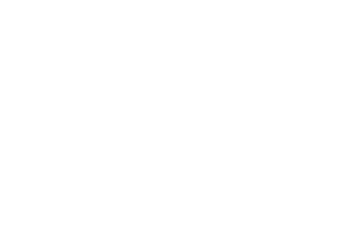

In [87]:
topics = []
for i,topic in LdaModel.show_topics(formatted=True, num_topics=n_topics, num_words=10):
    print(str(i)+": "+ topic)
    topics.append(topic)
    show_wordcloud(topic)
    print()

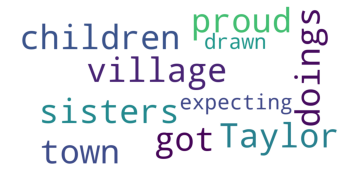

In [88]:
%matplotlib inline
plt.imshow(show_wordcloud(topics[0]))

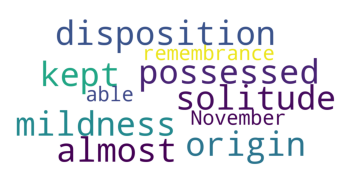

In [89]:
plt.imshow(show_wordcloud(topics[1]))

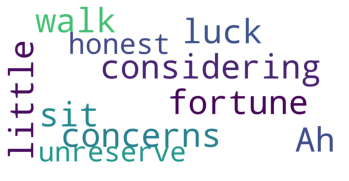

In [90]:
plt.imshow(show_wordcloud(topics[2]))

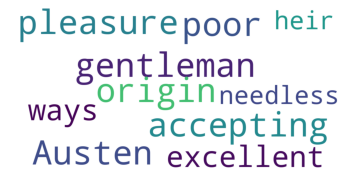

In [91]:
plt.imshow(show_wordcloud(topics[3]))

### Coherence Model

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

cm = CoherenceModel(model=LdaModel, corpus=corpus_austen, coherence='u_mass')
coherence = cm.get_coherence()  # get coherence value
coherence

In [ ]:
num_topic_list = np.arange(2,10,2)
for num in num_topic_list:
    LdaModel = gensim.models.ldamodel.LdaModel(corpus=corpus_austen,
                                           id2word=dictionary_austen,  
                                           num_topics=num,  
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
    cm = CoherenceModel(model=LdaModel, corpus=corpus_austen, coherence='u_mass') # 0 is the best coherence value
    coherence = cm.get_coherence()  # get coherence value
    print('Num of topics: ', num, ' | ', 'Coherence value:', coherence)    

In [ ]:
num_topic_list = np.arange(2,10,2)
for num in num_topic_list:
    lda_mallet = LdaMallet(
        mallet_path,
        corpus = corpus_austen,
        num_topics = num,
        id2word = dictionary_austen,
    )
    cm = CoherenceModel(model=lda_mallet, corpus=corpus_austen, coherence='u_mass') # 0 is the best coherence value
    coherence = cm.get_coherence()  # get coherence value
    print('Num of topics: ', num, ' | ', 'Coherence value:', coherence)   

#### NMF

In [ ]:
from sklearn.decomposition import NMF

# build tf-idf document-term matrix
# normalize and tokenize txt file
normalized_austen_corpus = normalize_corpus(austen_corpus, tokenize = False, remove_punc = True, remove_stopwords=True)

norm_corpus = normalize_corpus(normalized_austen_corpus)
vectorizer, tfidf_matrix = build_feature_matrix(norm_corpus, feature_type='tfidf') 

# build topic model
total_topics = 6
nmf = NMF(n_components=total_topics, random_state=42, alpha=.1, l1_ratio=.5) 
nmf.fit(tfidf_matrix) 

# get terms and their weights
feature_names = vectorizer.get_feature_names() 
weights = nmf.components_ 
topics = get_topics_terms_weights(weights, feature_names) 
print_topics_udf(topics=topics, total_topics=total_topics, num_terms=None, display_weights=True) 

### Sklearn LDA

In [ ]:
n_top_words = 3
n_components = 6

tf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf = tf_vectorizer.fit_transform(normalized_austen_corpus)


lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(tfidf)



tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words,n_components, 'Topics in LDA model')